<a href="https://colab.research.google.com/github/vhrique/anne_ptbr/blob/main/04_Arquiteturas_Especializadas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Introdução à Arquiteturas Especializadas

As arquiteturas clássicas de redes neurais, como as redes densas (MLPs), convolucionais (CNNs) e recorrentes (RNNs), são amplamente usadas para tarefas de classificação e regressão, aproveitando sua estrutura para extrair padrões dos dados e realizar previsões. Essas redes, em geral, aprendem a mapear entradas para saídas rotuladas e são versáteis em diferentes domínios.

No entanto, há arquiteturas especializadas que atendem a demandas mais específicas. Autoencoders, por exemplo, são redes projetadas para compressão de dados e extração de características latentes, enquanto GANs (Redes Generativas Adversárias) são usadas para a geração de dados sintéticos realistas. Em tarefas de visão computacional, arquiteturas voltadas para detecção de objetos e segmentação aprendem a identificar e localizar múltiplas classes em uma imagem, demonstrando a evolução do campo para resolver problemas além da classificação tradicional.

Nesta aula, falaremos mais sobre estes tipos de arquiteturas e como isto muda em relação à representação, avaliação e otimização de modelos.

# Arquiteturas Fundamentais para Reconstrução e Geração de Dados



## Autoencoders

Os autoencoders são um tipo de rede neural projetada para aprender uma representação compacta dos dados, também conhecida como codificação latente, de forma não supervisionada. Uma das suas primeiras idéias surgiu na década de 1980 por Geoffrey Hinton. Eles são compostos por duas partes principais: o codificador, que reduz a dimensionalidade dos dados de entrada ao projetá-los em um espaço latente de menor dimensão, e o decodificador, que tenta reconstruir os dados originais a partir dessa representação comprimida. A principal aplicação dos autoencoders está em tarefas como redução de dimensionalidade, remoção de ruído e geração de novas amostras.

<center><img src="https://github.com/vhrique/anne_ptbr/blob/main/figures/ae.jpg?raw=true" width=500></center>

A avaliação de autoencoders geralmente é feita comparando a similaridade entre os dados de entrada e sua reconstrução gerada pelo decodificador, utilizando métricas como erro quadrático médio (MSE) ou entropia cruzada, dependendo do tipo de dados. O objetivo é minimizar essa diferença, o que indica que o autoencoder aprendeu uma boa representação latente. A otimização dos autoencoders é realizada através de técnicas padrão de redes neurais, como a _backpropagation_ e o uso de algoritmos de otimização, como o gradiente descendente e suas variantes.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, input_size)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Variational Autoencoders

Os autoencoders variacionais (VAEs) são uma extensão dos autoencoders tradicionais que introduzem uma abordagem probabilística para a geração de dados (Kingma e Welling, 2013). Em vez de codificar os dados diretamente em um espaço latente fixo, os VAEs aprendem distribuições probabilísticas que representam as características latentes dos dados, com a rede aprendendo os parâmetros de média e variância dessas distribuições. Essa estrutura permite que o modelo gere novas amostras ao amostrar dessas distribuições latentes, o que torna os VAEs ideais para tarefas como síntese de dados, geração de imagens e aprendizado de características latentes com maior capacidade de generalização.

<center><img src="https://github.com/vhrique/anne_ptbr/blob/main/figures/vae.jpg?raw=true" width=600></center>

Em termos de avaliação e otimização, além da reconstrução dos dados, o VAE incorpora na função de perda um termo de regularização chamado divergência Kullback-Leibler (KL), que mede o quão próxima a distribuição latente aprendida está de uma distribuição normal padrão. A otimização, então, busca equilibrar dois objetivos: minimizar a perda de reconstrução, para garantir que a entrada seja bem reconstruída, e minimizar a divergência KL, para manter a estrutura latente bem regularizada. Esse processo permite que o VAE não apenas reconstrua os dados, mas também gere novas amostras de maneira mais controlada e com maior capacidade de generalização.

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_size):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 400),
            nn.ReLU()
        )
        self.mu_layer = nn.Linear(400, 20)
        self.logvar_layer = nn.Linear(400, 20)  # Log variância

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(20, 400),
            nn.ReLU(),
            nn.Linear(400, input_size),
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.mu_layer(encoded)
        logvar = self.logvar_layer(encoded)
        z = self.reparameterize(mu, logvar)
        decoded = self.decoder(z)
        return decoded, mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL Diverg.
    return BCE + KLD

## Generative Adversarial Networks

As Generative Adversarial Networks (GANs), introduzidas por Ian Goodfellow em 2014, são um tipo de rede neural composta por dois modelos que competem entre si: um gerador, que cria novos dados a partir de uma entrada aleatória, e um discriminador, que tenta distinguir entre os dados reais e os gerados. O gerador busca melhorar suas amostras de forma a "enganar" o discriminador, enquanto o discriminador tenta identificar corretamente os dados gerados. Esse processo adversarial resulta em um gerador capaz de produzir dados realistas, como imagens, vídeos, ou textos, que são quase indistinguíveis dos dados reais. GANs têm aplicações amplas em áreas como geração de imagens, super-resolução, e síntese de dados.

<center><img src="https://github.com/vhrique/anne_ptbr/blob/main/figures/gan.jpg?raw=true" width=600></center>

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, output_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, output_size),
            nn.Tanh()  # Para normalizar a saída entre [-1, 1]
        )

    def forward(self, z):
        img = self.model(z)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        validity = self.model(x)
        return validity

## Exemplo com MNIST

In [ ]:
batch_size = 64
latent_dim = 20
lr = 0.0002
epochs = 5

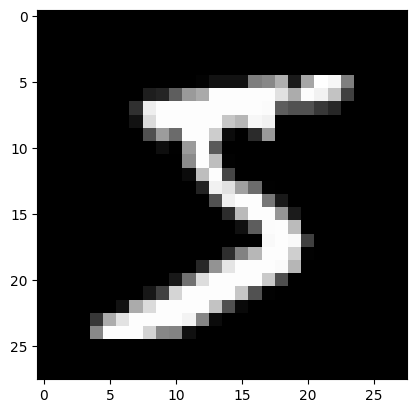

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

plt.imshow(dataset[0][0][0], cmap='gray')
plt.show()

In [ ]:
ae = Autoencoder(input_size=28*28)
optimizer = optim.Adam(ae.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(epochs):
    for imgs, _ in dataloader:
        imgs = imgs.view(imgs.size(0), -1)
        recon = ae(imgs)
        loss = criterion(recon, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

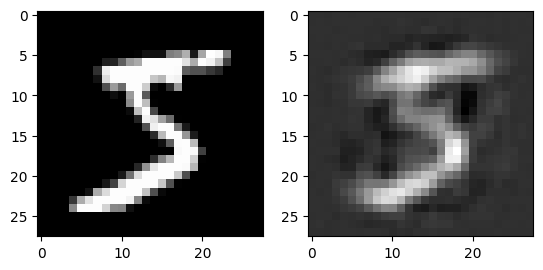

In [ ]:
fig, axs = plt.subplots(1,2)
output = ae(dataset[0][0].flatten())
axs[0].imshow(dataset[0][0][0].numpy(), cmap='gray')
axs[1].imshow(output.view(28, 28).detach().numpy(), cmap='gray')
plt.show()

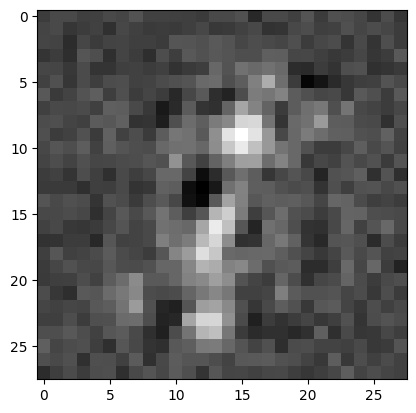

In [ ]:
output = ae.decoder(torch.randn(1,64))[0]
plt.imshow(output.view(28, 28).detach().numpy(), cmap='gray')
plt.show()

In [ ]:
vae = VAE(input_size=28*28)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld

for epoch in range(epochs):
    for imgs, _ in dataloader:
        imgs = imgs.view(imgs.size(0), -1)  # Flatten the image
        recon, mu, logvar = vae(imgs)
        loss = vae_loss(recon, imgs, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 2853.9924
Epoch [2/5], Loss: 2862.9500
Epoch [3/5], Loss: 2693.0376
Epoch [4/5], Loss: 2667.8523
Epoch [5/5], Loss: 2589.0564


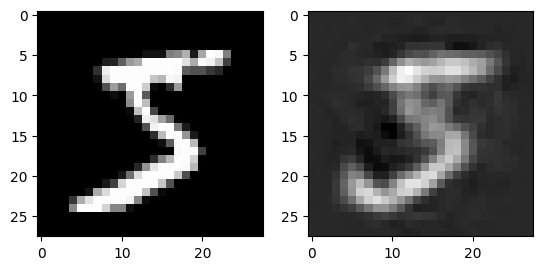

In [ ]:
fig, axs = plt.subplots(1,2)
output, _, _ = vae(dataset[0][0].flatten())
axs[0].imshow(dataset[0][0][0].numpy(), cmap='gray')
axs[1].imshow(output.view(28, 28).detach().numpy(), cmap='gray')
plt.show()

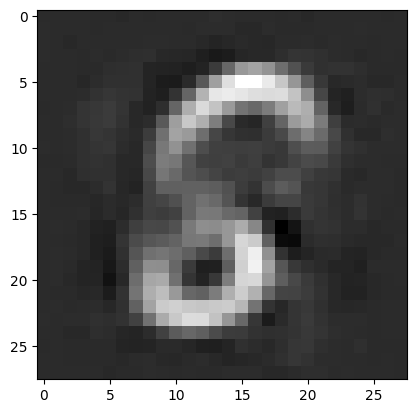

In [ ]:
output = vae.decoder(torch.randn(1,20))[0]
plt.imshow(output.view(28, 28).detach().numpy(), cmap='gray')
plt.show()

In [ ]:
generator = Generator(latent_dim, 28*28)
discriminator = Discriminator(28*28)
adversarial_loss = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

epochs = 10
for epoch in range(epochs):
    print(f'Epoch [{epoch+1}/{epochs}]')
    for i, (imgs, _) in enumerate(dataloader):
        # Ground truths
        real_imgs = imgs
        real_labels = torch.ones(imgs.size(0), 1)
        fake_labels = torch.zeros(imgs.size(0), 1)

        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Real images
        real_loss = adversarial_loss(discriminator(real_imgs.view(real_imgs.size(0), -1)), real_labels)

        # Fake images
        z = torch.randn(imgs.size(0), latent_dim)
        fake_imgs = generator(z)
        fake_loss = adversarial_loss(discriminator(fake_imgs.detach()), fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        # Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Train the generator to "fool" the discriminator
        g_loss = adversarial_loss(discriminator(fake_imgs), real_labels)
        g_loss.backward()
        optimizer_G.step()

        # Print the progress
        if (i % 400) == 0:
            print(f'\tBatch {i}/{len(dataloader)} Loss D: {d_loss.item()}, Loss G: {g_loss.item()}')

Epoch [1/10]
	Batch 0/938 Loss D: 1.399876594543457, Loss G: 0.672473132610321
	Batch 400/938 Loss D: 2.385497570037842, Loss G: 6.686275482177734
	Batch 800/938 Loss D: 0.006545062176883221, Loss G: 7.107415676116943
Epoch [2/10]
	Batch 0/938 Loss D: 0.0064580682665109634, Loss G: 6.3921685218811035
	Batch 400/938 Loss D: 0.002568259369581938, Loss G: 10.376607894897461
	Batch 800/938 Loss D: 0.1048927754163742, Loss G: 24.845191955566406
Epoch [3/10]
	Batch 0/938 Loss D: 0.23972977697849274, Loss G: 25.5443115234375
	Batch 400/938 Loss D: 0.19576714932918549, Loss G: 7.387028217315674
	Batch 800/938 Loss D: 0.2517167925834656, Loss G: 2.99017333984375
Epoch [4/10]
	Batch 0/938 Loss D: 0.015246842056512833, Loss G: 8.494224548339844
	Batch 400/938 Loss D: 0.03429083898663521, Loss G: 5.968017578125
	Batch 800/938 Loss D: 0.8867369890213013, Loss G: 5.245614051818848
Epoch [5/10]
	Batch 0/938 Loss D: 0.12478847801685333, Loss G: 8.270752906799316
	Batch 400/938 Loss D: 0.09666469693183

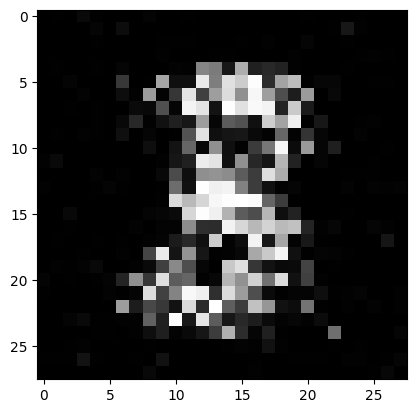

In [ ]:
output = generator(torch.randn(1,latent_dim))[0]
plt.imshow(output.view(28, 28).detach().numpy(), cmap='gray')
plt.show()

# Arquiteturas Especializadas em Visão Computacional

Em visão computacional, tarefas distintas como detecção de objetos, segmentação e geração de imagens exigem combinações específicas de camadas e funções de perda nas arquiteturas de rede. Por exemplo, a detecção de objetos pode combinar camadas convolucionais para extração de características com camadas de regressão para prever posições, utilizando funções de perda que equilibram precisão de classificação e localização. Na segmentação, são empregadas camadas que mantêm a resolução espacial para identificar pixels específicos, com funções de perda que medem a correspondência entre as previsões e as máscaras reais. Para geração de imagens, as arquiteturas incluem camadas que modelam distribuições de dados complexas, usando funções de perda que avaliam a qualidade e realismo das imagens produzidas. Dessa forma, a escolha adequada de camadas e funções de perda é crucial para atender aos requisitos de cada tarefa específica.

## Detecção de Objetos

As arquiteturas para detecção de objetos em visão computacional combinam diversos componentes para identificar e localizar objetos em imagens. Tipicamente, utilizam camadas convolucionais para extrair características relevantes, seguidas por mecanismos que propõem regiões de interesse onde os objetos possivelmente estão. Essas regiões são então refinadas e classificadas através de camadas específicas que prevêem tanto a categoria do objeto quanto a posição das caixas delimitadoras. Funções de perda apropriadas são aplicadas para otimizar simultaneamente a precisão da classificação e a exatidão da localização. A integração eficaz desses componentes é crucial para o desempenho de modelos de detecção de objetos.

<center><img src="https://github.com/vhrique/anne_ptbr/blob/main/figures/obj_detection.jpg?raw=true"></center>

### R-CNN (2014)

R-CNN (Regions with Convolutional Neural Networks) é uma arquitetura pioneira para detecção de objetos em visão computacional (Girshick et al, 2014). Ela funciona gerando propostas de regiões que possivelmente contêm objetos, usando algoritmos como busca seletiva. Cada região proposta é redimensionada e passada por uma rede neural convolucional para extração de características. Essas características são então alimentadas em um classificador, como uma SVM, para determinar a classe do objeto na região. Embora o R-CNN tenha melhorado significativamente a precisão na detecção de objetos, seu processamento é lento, pois cada região proposta precisa ser processada individualmente pela rede neural.

<center><img src="https://github.com/vhrique/anne_ptbr/blob/main/figures/rcnn.png?raw=true" width=700></center>

A função de perda (loss function) do R-CNN combina duas partes principais: uma perda de classificação e uma perda de regressão para as caixas delimitadoras. A perda de classificação é geralmente uma entropia cruzada que avalia a precisão da previsão da classe do objeto em cada região proposta. Já a perda de regressão avalia a precisão na predição das coordenadas da caixa delimitadora, geralmente usando um erro quadrático ou L1/L2 loss. Essas duas perdas são combinadas para ajustar a rede, garantindo que ela não apenas classifique corretamente os objetos, mas também localize-os de maneira precisa.

### Fast R-CNN (2015)

Fast R-CNN é uma melhoria significativa em relação ao R-CNN, projetada para acelerar o processo de detecção de objetos (Girshick, 2015). Em vez de extrair e classificar cada região proposta separadamente, o Fast R-CNN processa a imagem completa através de uma rede convolucional, gerando um mapa de características. As regiões de interesse (ROIs), geradas pelo Selective Search ou outro método, são então projetadas nesse mapa de características. Em vez de redimensionar as regiões, como no R-CNN original, o Fast R-CNN usa uma camada chamada ROI Pooling para extrair uma representação de tamanho fixo para cada ROI. Essas representações são passadas por camadas totalmente conectadas para classificação e regressão de caixas delimitadoras, tornando o processo mais rápido e eficiente.

<center><img src="https://github.com/vhrique/anne_ptbr/blob/main/figures/fast_rcnn.png?raw=true" width=700></center>

A função de perda do Fast R-CNN também combina duas partes: uma perda de classificação e uma perda de regressão para as caixas delimitadoras, semelhante ao R-CNN. A perda de classificação usa entropia cruzada para avaliar a precisão da previsão da classe dos objetos em cada região de interesse (ROI). A perda de regressão, por sua vez, utiliza uma smooth L1 loss para refinar as coordenadas das caixas delimitadoras, tornando o treinamento mais estável ao lidar com grandes variações de valores. Essas perdas são otimizadas conjuntamente, permitindo que o Fast R-CNN seja eficiente tanto em classificar objetos quanto em prever suas localizações com precisão.

### Faster R-CNN (2015)

Faster R-CNN é uma evolução do Fast R-CNN, introduzida por Ren et al (2015), que elimina a dependência de métodos heurísticos como o Selective Search para gerar regiões propostas. Em vez disso, ele introduz a Region Proposal Network (RPN), uma rede neural que é treinada para gerar as regiões de interesse diretamente a partir do mapa de características da imagem. A RPN analisa janelas deslizantes sobre o mapa de características e prevê a probabilidade de cada janela conter um objeto, além de ajustar as caixas delimitadoras. Essas regiões propostas pela RPN são então refinadas e classificadas pela segunda parte do modelo, similar ao Fast R-CNN. Ao tornar a proposta de regiões uma parte treinável da rede, o Faster R-CNN é muito mais rápido e preciso, unificando a detecção de objetos em uma única arquitetura eficiente.

<center><img src="https://github.com/vhrique/anne_ptbr/blob/main/figures/faster_rcnn.png?raw=true" width=400></center>

A função de perda da Faster R-CNN combina duas partes: a perda da Region Proposal Network (RPN) e a da rede de detecção. A perda da RPN inclui uma entropia cruzada binária para classificar se as anchors contêm objetos, definido a partir da intersecção sobre a união (IoU), e uma smooth L1 loss para ajustar as caixas propostas. Na rede de detecção, utiliza-se uma entropia cruzada para classificar os objetos nas regiões de interesse (ROIs) e uma smooth L1 loss adicional para refinar as coordenadas das caixas delimitadoras. Essas perdas são combinadas para otimizar simultaneamente a proposta de regiões e a precisão na detecção de objetos.

### YOLO (2015 - ...)

YOLO (You Only Look Once) é uma abordagem inovadora para detecção de objetos que se diferencia por tratar a tarefa como um problema de regressão de ponta a ponta (Redmon et al, 2015). Em vez de gerar regiões de interesse e classificá-las separadamente, como nas arquiteturas baseadas em R-CNN, o YOLO divide a imagem em uma grade e, para cada célula, prevê diretamente as classes de objetos e as caixas delimitadoras. Isso permite que toda a imagem seja processada em uma única passagem pela rede, tornando o YOLO extremamente rápido em comparação com métodos tradicionais. Embora tenha uma troca inicial entre velocidade e precisão, versões mais recentes de YOLO têm melhorado significativamente o desempenho em ambos os aspectos, sendo amplamente utilizado em aplicações em tempo real.

<center><img src="https://github.com/vhrique/anne_ptbr/blob/main/figures/yolo.png?raw=true" width=500></center>

A função de perda do YOLO é composta por três partes principais: a perda de localização, que utiliza mean squared error (MSE) para ajustar as coordenadas das caixas delimitadoras preditas em relação às reais; a perda de confiança, que também usa MSE para avaliar a precisão na previsão da presença de objetos nas células da grade; e a perda de classificação, que aplica entropia cruzada para penalizar previsões incorretas das classes dos objetos. Essas perdas são ponderadas e combinadas para otimizar simultaneamente a localização, a presença e a classificação dos objetos detectados.

#### Evoluções

As evoluções do YOLO (You Only Look Once) visam aprimorar tanto a precisão quanto a eficiência da detecção de objetos. Desde o YOLO original, várias versões têm sido desenvolvidas. O YOLOv2 introduziu melhorias como a utilização de ancoras (anchor boxes) para lidar melhor com a detecção de objetos de diferentes escalas. O YOLOv3 (Redmon, 2018) adicionou uma arquitetura de rede mais profunda com detecção em múltiplas escalas, permitindo melhor precisão em objetos pequenos. O YOLOv4 otimizou ainda mais a velocidade e a precisão, incorporando avanços como convoluções otimizadas e estratégias de regularização. Mais recentemente, o YOLOv5 e YOLOv7 seguiram a tendência de otimizar o desempenho em hardware especializado, como GPUs, trazendo melhorias em velocidade e implementação prática, tornando o modelo ainda mais adequado para aplicações em tempo real e com maior capacidade de generalização.

### RetinaNet (2017)

RetinaNet é uma arquitetura de detecção de objetos que introduziu a Focal Loss para lidar com o problema de desbalanceamento entre classes de fundo e classes de objetos, comum em tarefas de detecção (Lin et al, 2017). Diferente das abordagens de duas etapas, como Faster R-CNN, RetinaNet adota uma estrutura de etapa única, semelhante ao YOLO, em que as previsões de classe e localizações de caixas delimitadoras são feitas diretamente a partir de mapas de características extraídos por uma rede backbone, como a ResNet. A principal inovação é a Focal Loss, que atribui menor peso às previsões de exemplos fáceis (geralmente de fundo) e foca mais nos exemplos difíceis, melhorando a detecção de objetos pequenos e difíceis de identificar, sem comprometer a eficiência. RetinaNet equilibra precisão e velocidade, tornando-se uma alternativa eficaz para detecção de objetos em larga escala.

<center><img src="https://github.com/vhrique/anne_ptbr/blob/main/figures/retinanet.png?raw=true" width=700></center>

O RetinaNet utiliza duas funções de perda principais: a Focal Loss para a tarefa de classificação, que ajusta a entropia cruzada tradicional para lidar com o desbalanceamento entre fundo e objetos, focando mais nos exemplos difíceis e ignorando os bem classificados, e a Smooth L1 Loss para a regressão das caixas delimitadoras, que penaliza os erros de maneira suave, proporcionando um ajuste mais estável das caixas. Essas duas funções são combinadas para otimizar tanto a precisão da classificação quanto a exatidão da localização dos objetos detectados.

#### Feature Pyramid Network (2016)

A Feature Pyramid Network (FPN) utilizada no RetinaNet é um componente chave que melhora a detecção de objetos em diferentes escalas (Lin et al, 2016). A FPN é uma arquitetura de rede projetada para construir uma representação em múltiplas resoluções da imagem de entrada, extraindo características em várias camadas, desde as mais detalhadas (para objetos pequenos) até as mais abstratas (para objetos maiores).

No RetinaNet, a FPN utiliza uma abordagem "top-down", onde as características de camadas mais profundas e coarser (com menos resolução) são combinadas com as de camadas mais rasas e detalhadas, resultando em uma pirâmide de características que permite detectar objetos de diversos tamanhos de forma eficiente. Isso melhora significativamente a precisão em comparação com métodos que utilizam apenas a última camada da rede convolucional, tornando o RetinaNet mais eficaz para detectar objetos pequenos e em diferentes escalas.

### DETR (2020)

DETR (Detection Transformer) é uma arquitetura inovadora para detecção de objetos que combina redes neurais com o mecanismo de Transformers (Carion et al, 2020). Ao contrário das abordagens tradicionais baseadas em convoluções e region proposals, o DETR trata a detecção de objetos como um problema de correspondência entre um conjunto fixo de previsões e objetos presentes na imagem. Ele usa um backbone convolucional para extrair características da imagem, seguido por camadas de Transformers que modelam as relações globais entre as características e produzem previsões diretas para as caixas delimitadoras e classificações. DETR é único por dispensar o uso de heurísticas como Non-Maximum Suppression (NMS) e propostas de regiões, proporcionando uma abordagem simplificada e direta. Apesar de ser mais lento no treinamento inicial, o DETR demonstra forte desempenho em termos de precisão e generalização, especialmente em cenários complexos com sobreposição de objetos.

<center><img src="https://github.com/vhrique/anne_ptbr/blob/main/figures/detr_2.png?raw=true" width=800></center>

O DETR utiliza três componentes principais em sua função de perda: a Matching Loss, baseada no algoritmo de Hungarian matching, que faz a correspondência entre as previsões e os objetos reais; a perda de classificação, que usa entropia cruzada para penalizar previsões incorretas de classe; e a perda de regressão das caixas delimitadoras, que combina L1 loss para ajustar as coordenadas das caixas e generalized IoU loss para melhorar o alinhamento entre as caixas preditas e as reais. Essas perdas são otimizadas em conjunto para garantir precisão tanto na classificação quanto na localização dos objetos.

## Segmentação de Imagens

Imagem

<center><img src="https://github.com/vhrique/anne_ptbr/blob/main/figures/image_segmentation.png?raw=true" width=500></center>

### FCN (2015)

### U-Net (2015)

### DeepLab (2015 - ...)

### Mask R-CNN (2017)

### SAM (2023)

## Geração e Transformação de Imagens

### StyleGAN


### CycleGAN

### PixelRNN

### Outras Arquiteturas

# Arquiteturas para Processamento de Linguagem Natural

## Seq2Seq

## Transformers

# Referências

- Rumelhart, D. E., Hinton, G. E., & Williams, R. J. (1986). Learning internal representations by error propagation. Parallel distributed processing, explorations in the microstructure of cognition.
- Kingma, D. P. (2013). Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114.
- Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., ... & Bengio, Y. (2014). Generative adversarial nets. Advances in neural information processing systems, 27.
- Girshick, R., Donahue, J., Darrell, T., & Malik, J. (2014). Rich feature hierarchies for accurate object detection and semantic segmentation. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 580-587).
- Girshick, R. (2015). Fast r-cnn. arXiv preprint arXiv:1504.08083.
- Ren, S. et al. (2015). Faster r-cnn: Towards real-time object detection with region proposal networks. arXiv preprint arXiv:1506.01497.
- Redmon, J., Divvala, S., Girshick, R., & Farhadi, A. (2015). You only look once: unified, real-time object detection (2015). arXiv preprint arXiv:1506.02640, 825.
- Redmon, J. (2018). Yolov3: An incremental improvement. arXiv preprint arXiv:1804.02767.
- Lin, T. Y., Dollár, P., Girshick, R., He, K., Hariharan, B., & Belongie, S. (2017). Feature pyramid networks for object detection. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2117-2125).
- Lin, T. (2017). Focal Loss for Dense Object Detection. arXiv preprint arXiv:1708.02002.
- Carion, N., Massa, F., Synnaeve, G., Usunier, N., Kirillov, A., & Zagoruyko, S. (2020, August). End-to-end object detection with transformers. In European conference on computer vision (pp. 213-229). Cham: Springer International Publishing.